In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fredapi as f
import seaborn as sns
import os
import sys

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:

sys.path.insert(0,'..') if '..' not in sys.path else _

In [3]:
''' 
Fred requires that user creates a key before they can download their data free.
I have created this key and you would need to create one at their site
'''
from secret import akey
fred = f.Fred(api_key=akey)

In [4]:
## Source fred
## https://fred.stlouisfed.org/series/GDPC1
## https://fred.stlouisfed.org/series/CPGDPAI -- Percent Change, Seasonally Adjusted Annual Rate
#gdp_file = '../Data/GDPC1.csv'

In [5]:
#df = pd.read_csv(gdp_file,parse_dates=['DATE'],index_col='DATE') 
df = pd.DataFrame(fred.get_series('CPGDPAI'),columns=['gdp'])

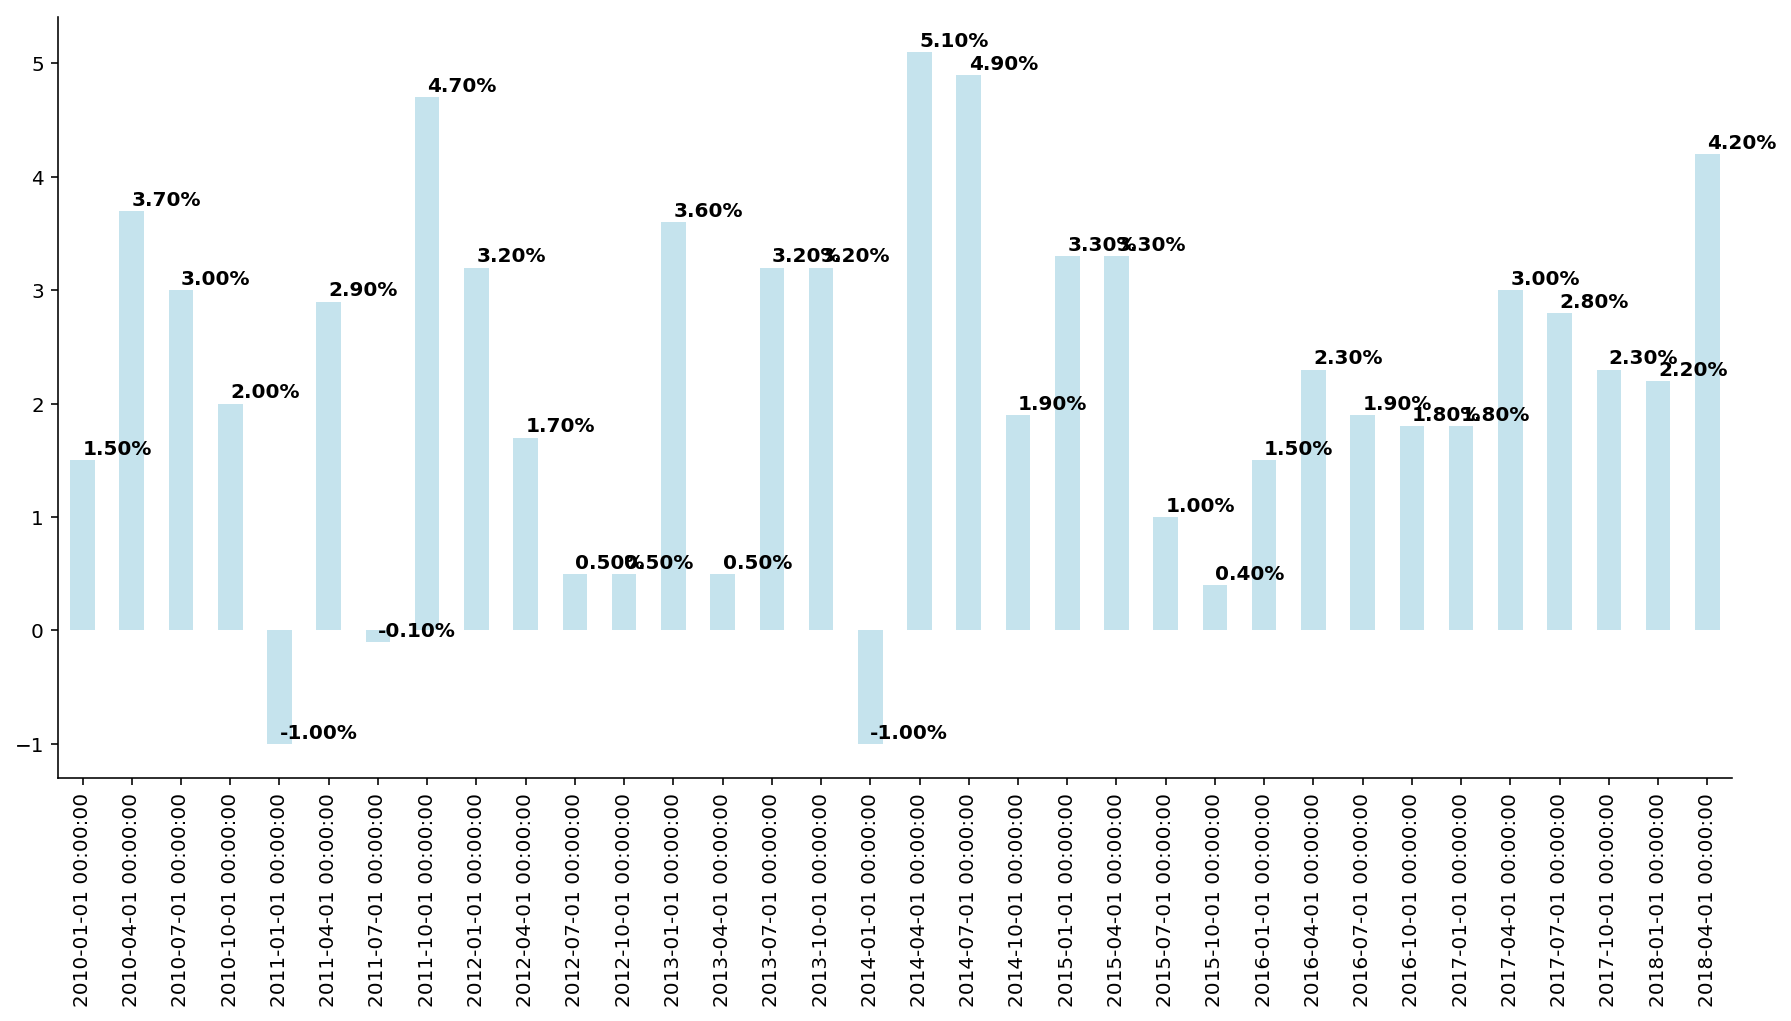

In [6]:
res = df['2010':]['gdp'].plot.bar(figsize=[15,7],alpha = 0.7,color='lightblue');
for idx , val in enumerate(df['2010':].gdp.values):
    caption = '{:.2%}'.format(val/100)
    res.text(x=idx,y=val + 0.05,s=caption, color = 'black',weight='bold')
sns.despine()

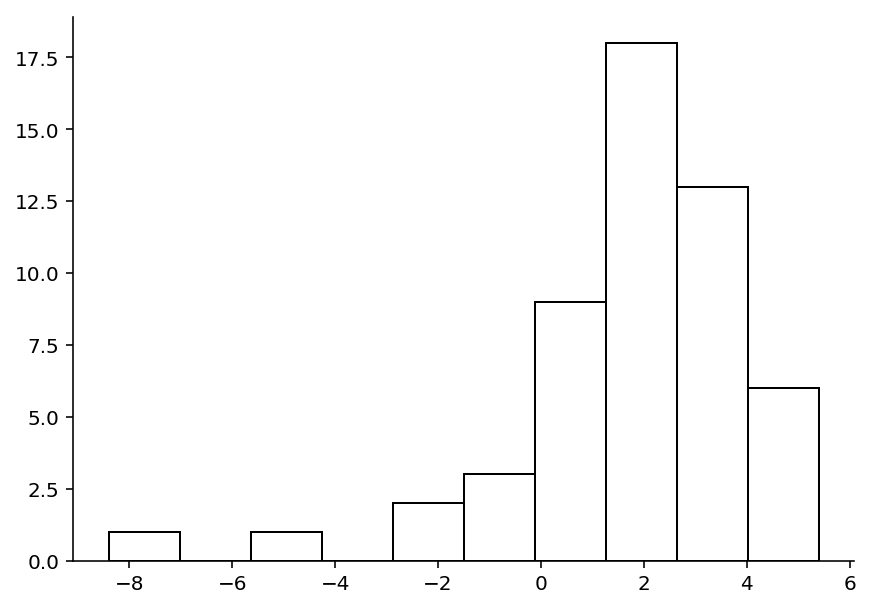

In [7]:
df.gdp.hist(grid=False,fill=False,figsize=[7,5])
sns.despine()

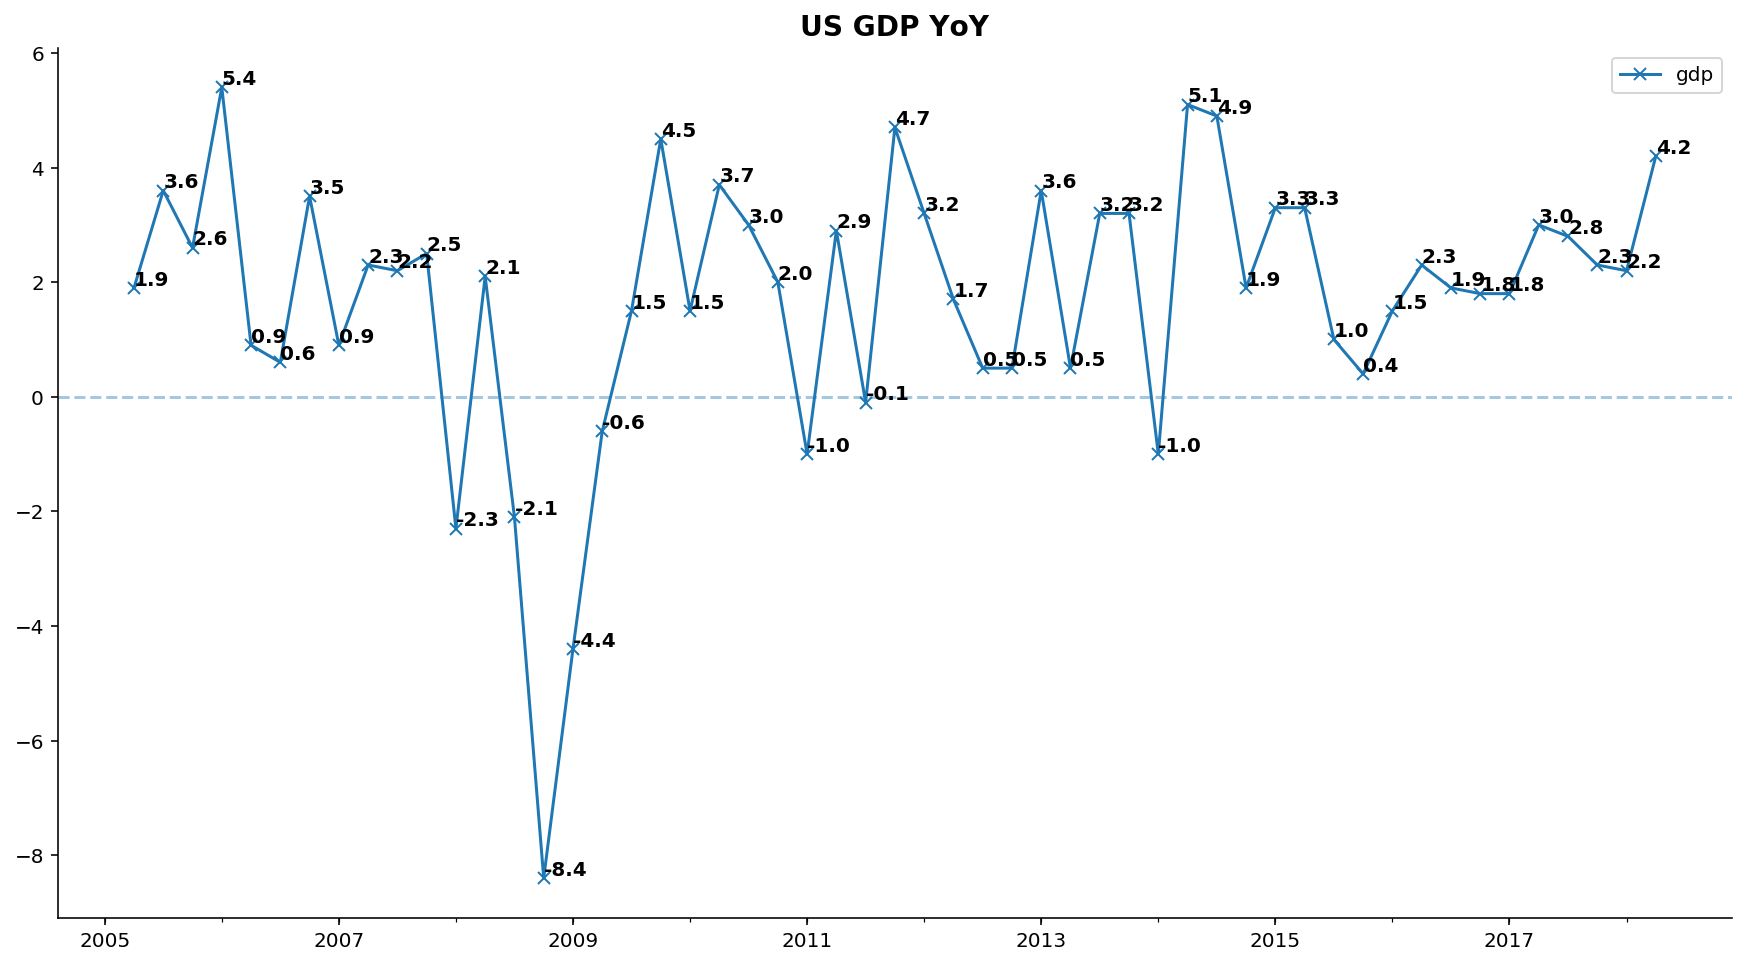

In [141]:
dt = df
dt.plot(figsize=[15,8],marker='x')
plt.axhline(0,alpha = 0.4, linestyle = '--')
for i in range(dt.shape[0]):
    val = dt.iloc[i].values[0]
    plt.text(x=dt.index[i],y= val + 0.05, s= str(val), color = 'black',weight='bold')
sns.despine()
plt.title('US GDP YoY',weight = 'bold', fontsize=14);

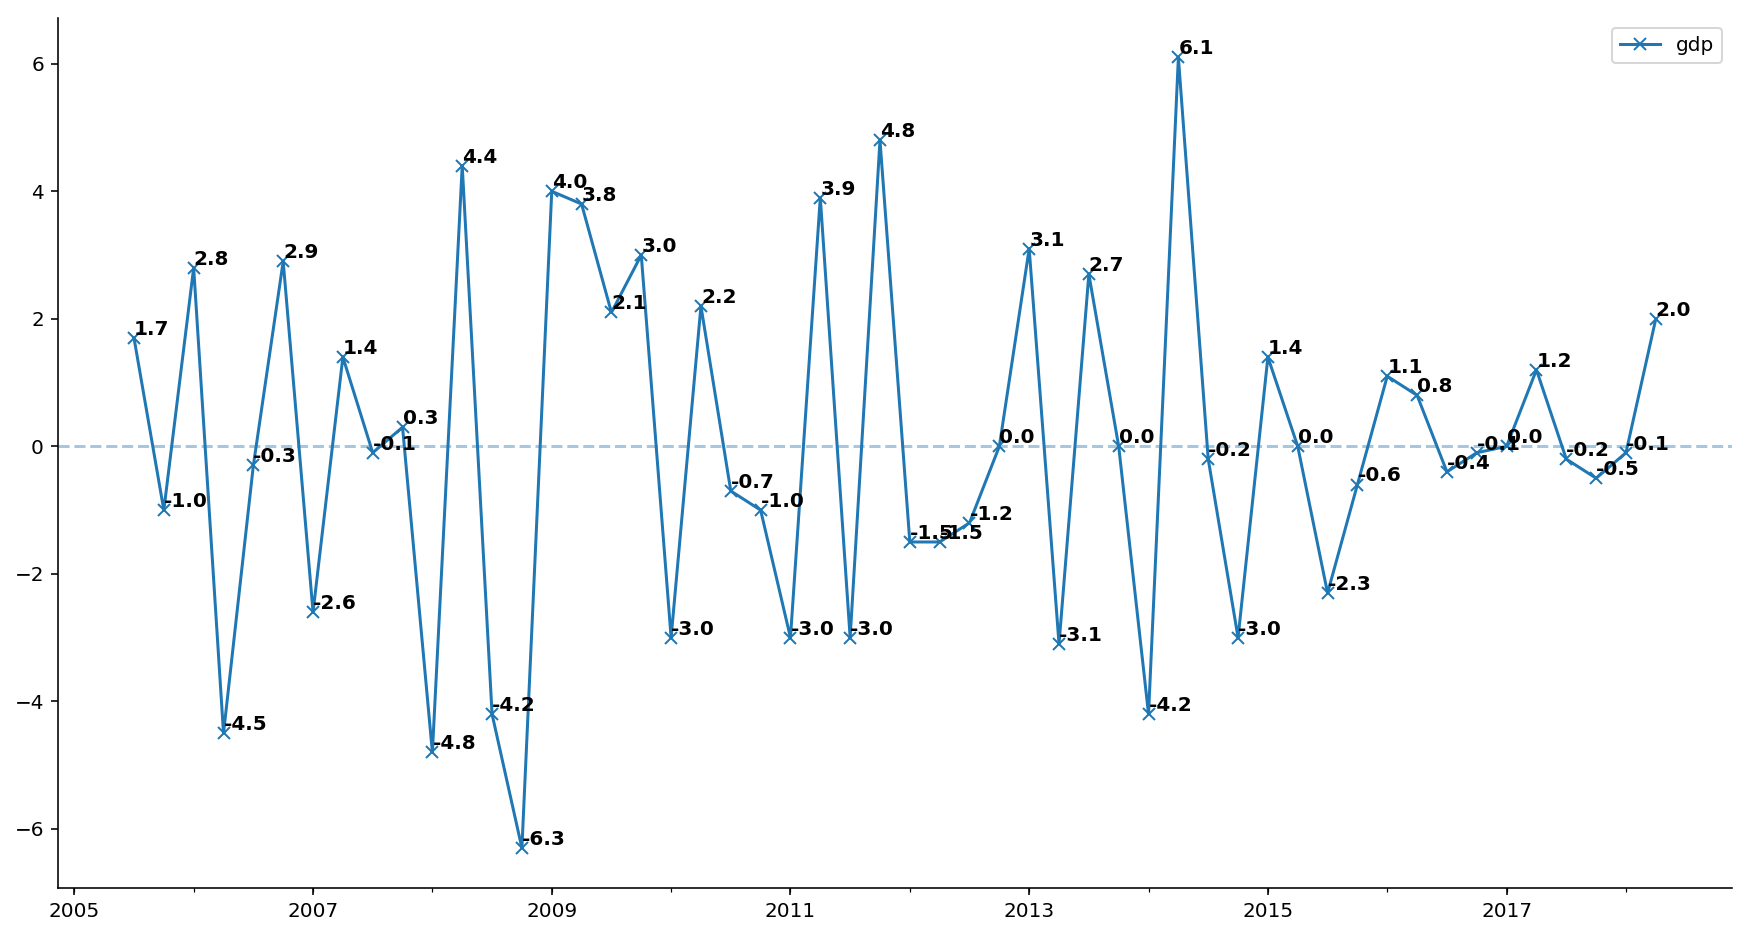

In [82]:
dt = df.diff()[1:]
dt.plot(figsize=[15,8],marker='x')
plt.axhline(0,alpha = 0.4, linestyle = '--')
for i in range(dt.shape[0]):
    val = dt.iloc[i].values[0]
    caption = str(np.round(val,2))
    plt.text(x=dt.index[i],y= val + 0.05, s= caption, color = 'black',weight='bold')
sns.despine()

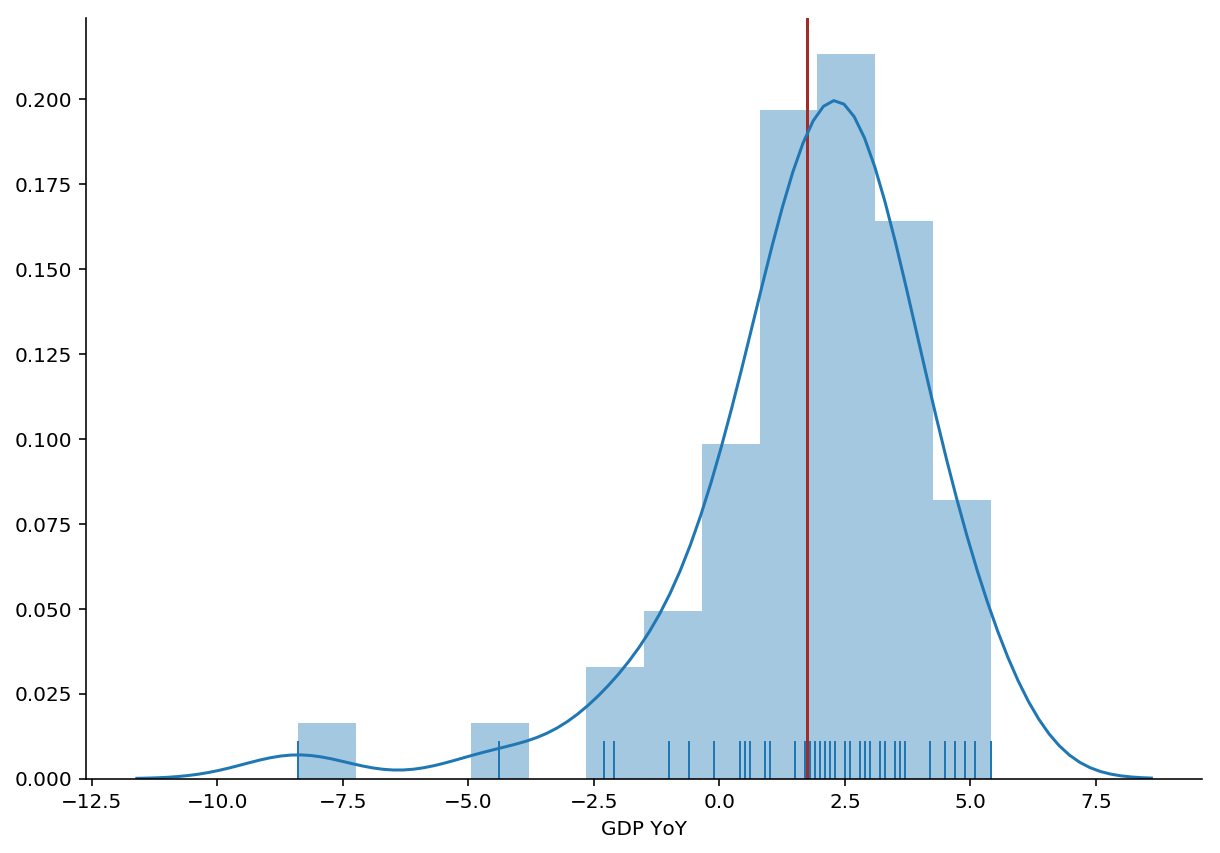

In [150]:
gdp_ts = dt.gdp.values
plt.figure(figsize=[10,7])
plt.axvline(np.mean(gdp_ts),color='brown')
#plt.hist(gdp_ts,alpha = 0.3, bins = 30, fill = False);
sns.distplot(gdp_ts,rug = True,axlabel='GDP YoY')
sns.despine()

## Decompose the time series and observe components

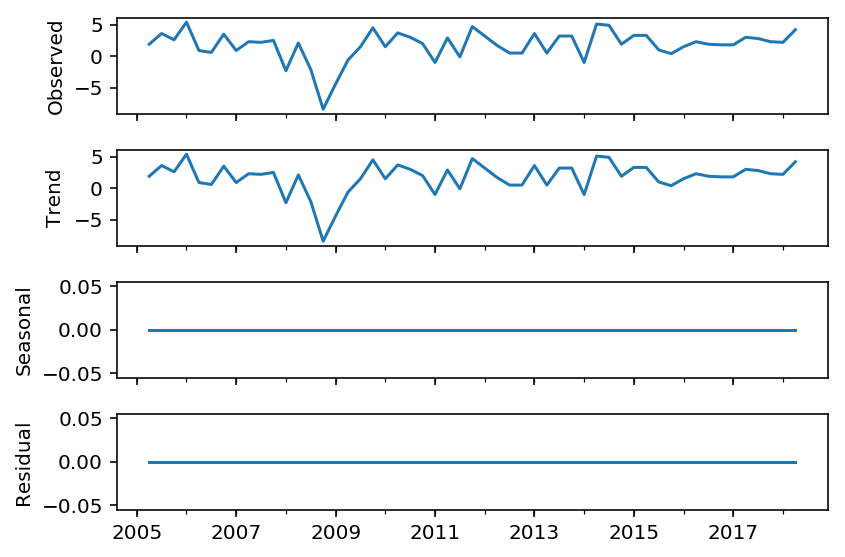

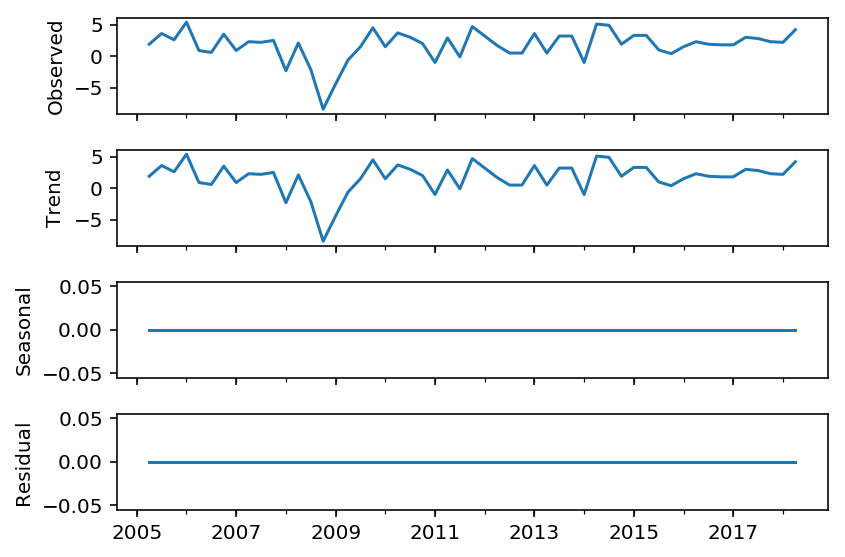

In [165]:
components = seasonal_decompose(dt.gdp, model = 'additive', freq = 1)
#plt.figure(figsize=[10,5])
components.plot()

## Autocorrelation and Partial Autocorrelation

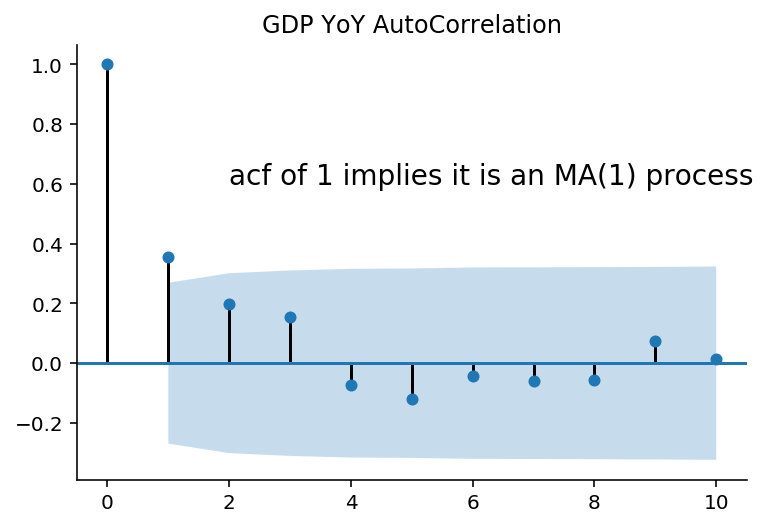

In [170]:
_ = plot_acf(gdp_ts,lags=10, title='GDP YoY AutoCorrelation')
sns.despine();
s = 'acf of 1 implies it is an MA(1) process'
plt.text(x = 2, y = 0.6, s = s, fontsize=14);

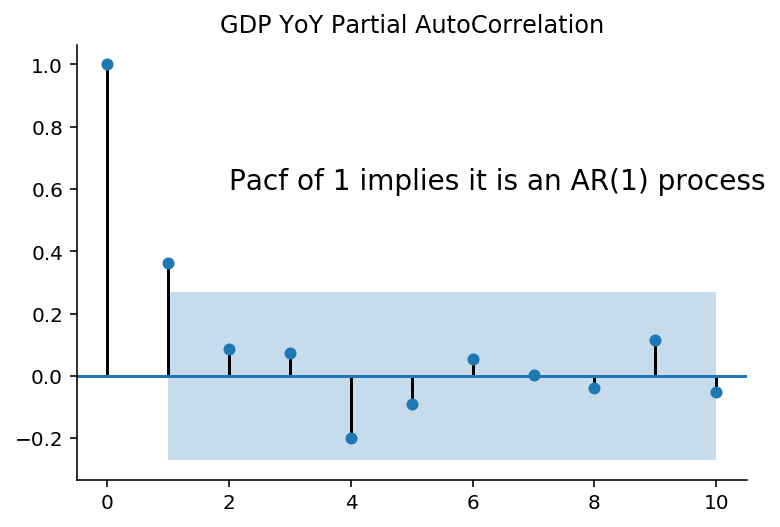

In [169]:
_ = plot_pacf(gdp_ts,lags=10, title='GDP YoY Partial AutoCorrelation')
sns.despine()
s = 'Pacf of 1 implies it is an AR(1) process'
plt.text(x = 2, y = 0.6, s = s, fontsize=14);

## Testing for stationarity
- The decomposed series clearly shows the trend ..so it is not a stationary process  

In [233]:
dt_diff = dt.diff()[1:]
dt_diff['MA GDP'] = dt.rolling(20).mean()
dt_diff['Moving Std GDP'] = dt.rolling(20).std()
res = adfuller(dt_diff.gdp.values.squeeze(),autolag = 'AIC')
p_value = res[1]
s = 'stationary as shown by ADF' if p_value <= 0.05 else 'Non Stationary'
print('p_value for ADF test is {} and time series is {}'.format(p_value,s))

p_value for ADF test is 5.519484887309227e-11 and time series is stationary as shown by ADF


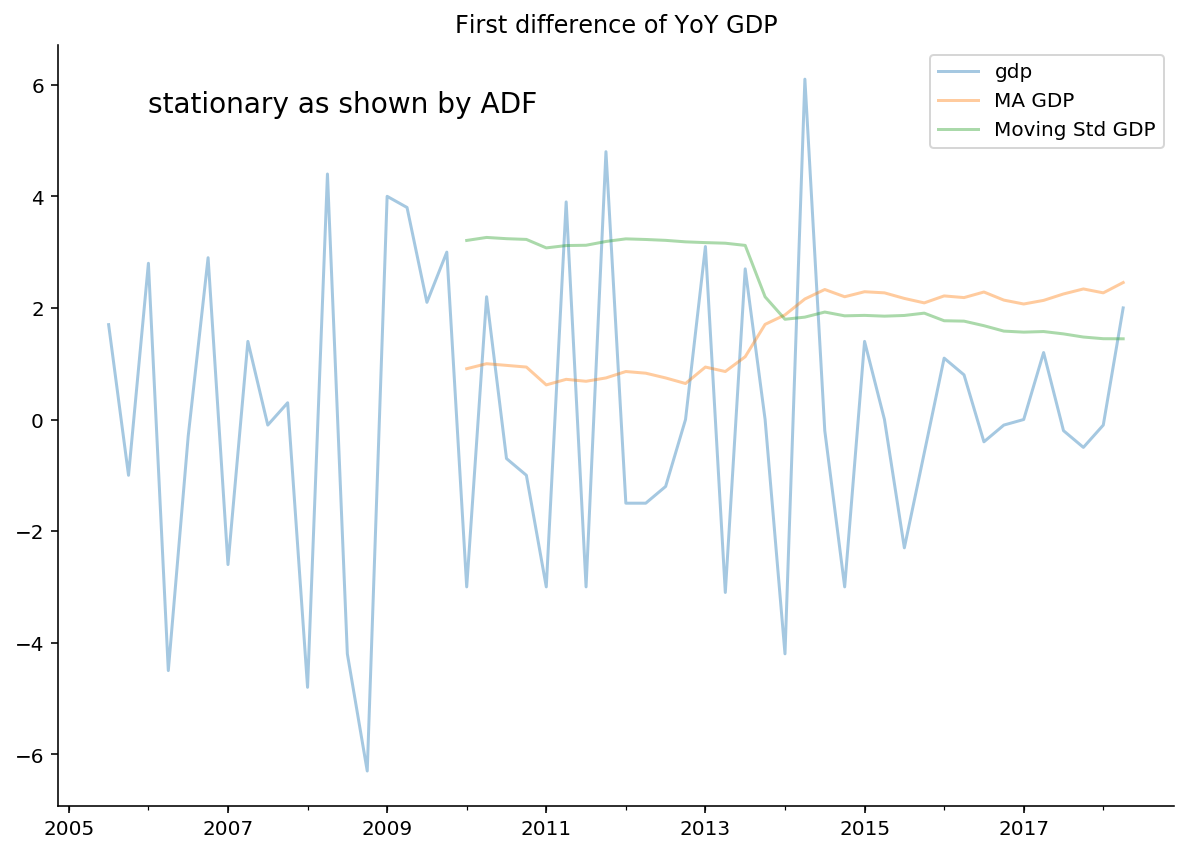

In [231]:
res = dt_diff.plot(figsize = [10,7],title='First difference of YoY GDP',alpha = 0.4)
res.text('2006',5.5,s,fontsize=14)
sns.despine()

## Fit an arima model with parameters 

In [128]:
arima_model = ARIMA(df.values.squeeze(), order=(1,1,1))
res = arima_model.fit()

In [129]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   52
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -116.588
Method:                       css-mle   S.D. of innovations              2.208
Date:                Mon, 21 Jan 2019   AIC                            241.176
Time:                        22:08:50   BIC                            248.981
Sample:                             1   HQIC                           244.168
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0293      0.030      0.974      0.335      -0.030       0.088
ar.L1.D.y      0.3602      0.132      2.721      0.009       0.101       0.620
ma.L1.D.y     -1.0000      0.059    -17.002      0.000      -1.115      -0.885
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7760           +0.0000j            2.7760            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [130]:
fittedvalues = res.fittedvalues
arparams = res.arparams.squeeze()
maparams = res.maparams

In [131]:
predicted = pd.Series(fittedvalues)

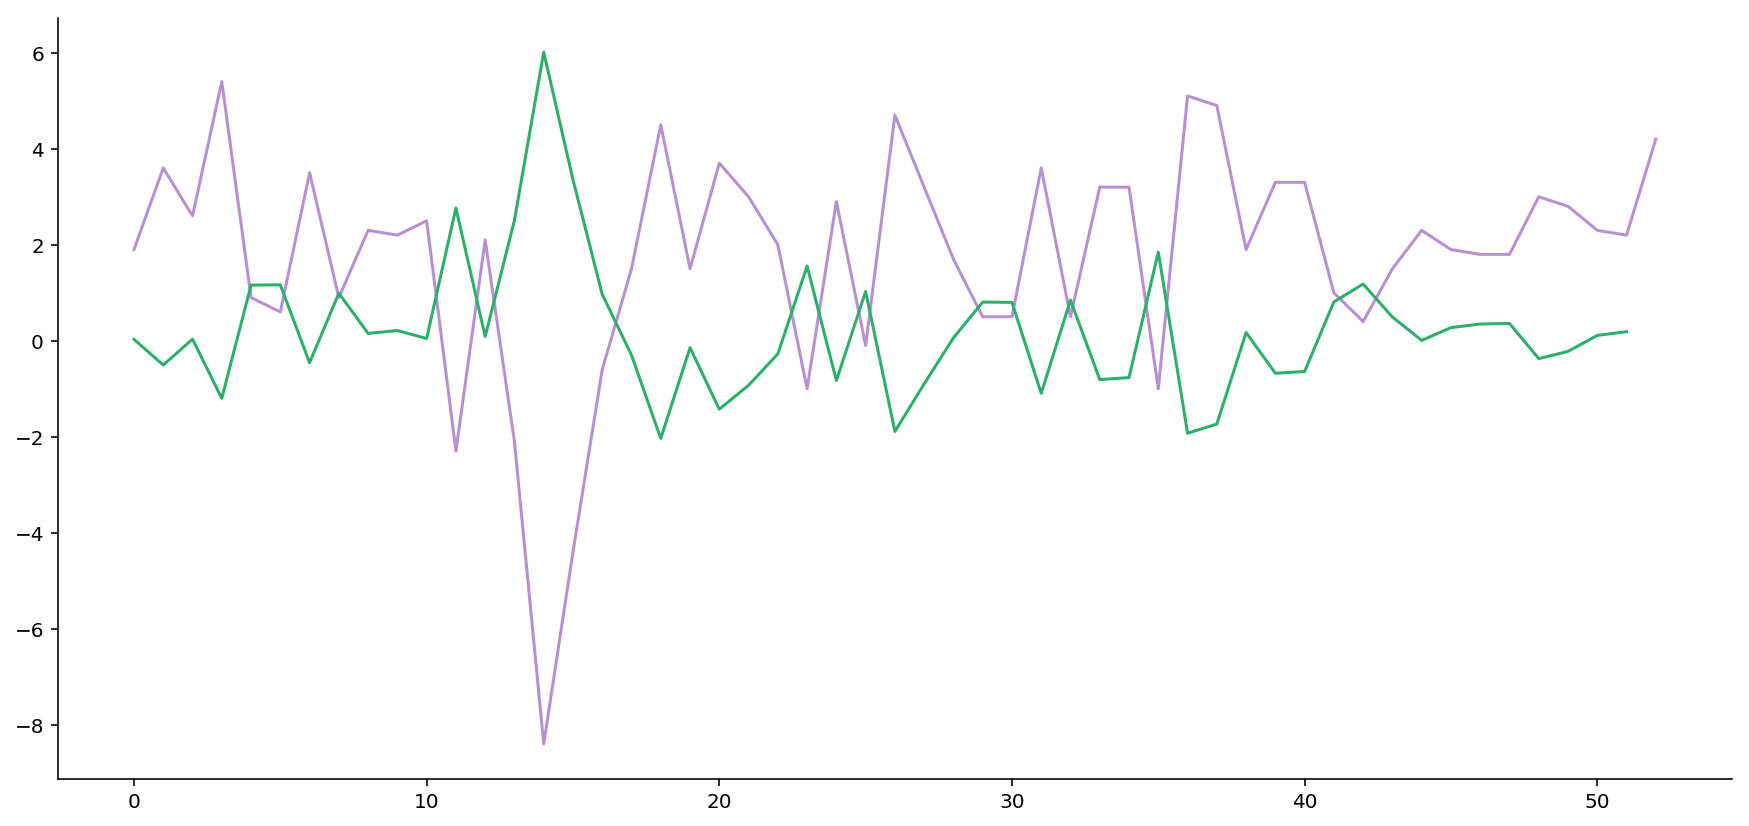

In [137]:
plt.figure(figsize= (15,7));
plt.plot(df.values.squeeze(),  color=sns.xkcd_rgb["pale purple"]);
plt.plot(predicted, color=sns.xkcd_rgb["jade green"]);
sns.despine()

In [136]:
res.forecast(steps=1,)

(array([3.12938731]), array([2.20788747]), array([[-1.19799261,  7.45676723]]))